In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import empyrical as emp
import time
import random
# from concurrent.futures import ProcessPoolExecutor

from common.log import *
from common.config import Config
from spider.spider_nasdaq import Spider_nasdaq

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts

CONF = Config().data[0]
MONGODB = CONF['MONGODB']
NASDAQ = CONF['NASDAQ']
CRYPTOCURRENCY = CONF['CRYPTOCURRENCY']
NASDAQ100 = CONF['NASDAQ100']

pd

<module 'pandas' from 'd:\\python3\\lib\\site-packages\\pandas\\__init__.py'>

In [2]:
%%time

spider = Spider_nasdaq()
timeframe = '10y'
ignore = True

# for symbol in NASDAQ100:
for symbol in ['NDX', 'TSLA']:
#     if symbol == 'SHPG':
#         ignore = False
#     if ignore:
#         continue
#     datafile = spider.get_stock_data(symbol, timeframe)
#     print(datafile)
    pass

Wall time: 0 ns


In [3]:
%%time

### 时间设置
start_date = '2008-06-02'
# start_date = '2010-01-01'
# start_date = '2015-01-01'
# start_date = '2017-01-03'
# start_date = '2018-01-01'
end_date = '2018-06-06'

TURTLE_POS = 20
### Turtle System One - Short
TURTLE_SHORT_BUY_N = 20
TURTLE_SHORT_SELL_N = 20
### Turtle System Two - Long
TURTLE_LONG_BUY_N = 60
TURTLE_LONG_SELL_N = 60

### 业务设置
IS_HAPPYMONEY = False
IS_TAX = False
IS_SLIPPAGE = True
IS_RANDOM_BUY = True
START_MONEY = 10000
HAPPY_MONEY = 0
PROPERTY = START_MONEY
CASH = START_MONEY


Wall time: 0 ns


In [4]:
%%time

stock_df_dict = {}

for symbol in NASDAQ100[:]:
    stock_data_file = '../database/market/%s.csv' % symbol
    stock_df = pd.read_csv(stock_data_file)

    # 筛选字段
#     stock_df = stock_df.loc[:, ['date', 'open', 'close']]

    # 去掉Nasdaq行情首行的当天行情
    if symbol in NASDAQ:
        stock_df = stock_df.drop([0])

    # 抛弃空值异常值
    stock_df.dropna(axis=0, how='any', inplace=True)

    # 格式化日期
    # 1.48 s ± 45.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#     stock_df['date'] = stock_df['date'].apply(lambda x: pd.Period(x, freq='D'))

    # 445 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    stock_df = stock_df.assign(date=pd.to_datetime(stock_df['date']))  # need .index.to_period('D')

    # 476 ms ± 46.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#     stock_df['date'] = pd.to_datetime(stock_df['date'])  # need .index.to_period('D')
    
    # 转换字段格式
#     stock_df = stock_df.astype(dtype={'volume': 'float64'})

    # 用日期作索引，日期升序排序
    # 95.1 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
    stock_df = stock_df[::-1]
    
    # 407 µs ± 5.07 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
#     %timeit stock_df.set_index(['date'], inplace=False)

    # Wall time: 500 µs
    stock_df.set_index(['date'], inplace=True)
    
    # 305 µs ± 2.75 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
#     stock_df = stock_df.sort_index(axis=0, ascending=True)
    
    # 822 µs ± 41.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
    stock_df.index = stock_df.index.to_period('D')

    # 计算涨跌幅
#     stock_df['c_pct_chg'] = stock_df.close.pct_change(1)
    stock_df['o_pct_chg'] = stock_df.open.pct_change(1)
    
    # Turtle指标
#     stock_df['TR1'] = abs(stock_df['high'] - stock_df['low'])
#     stock_df['TR2'] = abs(stock_df['high'] - stock_df['close'].shift())
#     stock_df['TR3'] = abs(stock_df['low'] - stock_df['close'].shift())
#     stock_df['TR'] = stock_df[['TR1', 'TR2', 'TR3']].max(axis=1)
#     stock_df['N'] = stock_df['TR'].rolling(20).mean()
#     stock_df['UNIT'] = (0.01 * START_MONEY) / (stock_df['N'])
    stock_df['ROLLING_%d_MAX' % TURTLE_SHORT_BUY_N] = stock_df['open'].rolling(TURTLE_SHORT_BUY_N).max()
    stock_df['ROLLING_%d_MIN' % TURTLE_SHORT_SELL_N] = stock_df['open'].rolling(TURTLE_SHORT_SELL_N).min()
    stock_df['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N] = stock_df['open'].rolling(TURTLE_LONG_BUY_N).max()
    stock_df['ROLLING_%d_MIN' % TURTLE_LONG_SELL_N] = stock_df['open'].rolling(TURTLE_LONG_SELL_N).min()
#     stock_df['MA%d' % TURTLE_BUY_N] = stock_df['open'].rolling(TURTLE_BUY_N).mean()
#     stock_df['MA%d' % TURTLE_SELL_N] = stock_df['open'].rolling(TURTLE_SELL_N).mean()
#     stock_df['EWMA'] = stock_df['open'].ewm(alpha=0.1, adjust=False).mean()
    stock_df['MA360'] = stock_df['open'].rolling(360).mean()
    stock_df['MA180'] = stock_df['open'].rolling(180).mean()
    stock_df['MA60'] = stock_df['open'].rolling(30).mean()
    stock_df['MA30'] = stock_df['open'].rolling(30).mean()
    
#     stock_df['ops'] = ''
#     stock_df['profit'] = 0
    
    # 减少数据
    # stock_df = stock_df['2016-01-01':]
    stock_df.dropna(how='any', inplace=True)
#     stock_df.drop(columns=['volume', 'TR1', 'TR2', 'TR3'], inplace=True)
    
    stock_df_dict[symbol] = stock_df
    
#     print(stock_df.head(10))
#     print(stock_df.dtypes)
#     print(stock_df.index[0])
#     print(type(stock_df.index[0]))

Wall time: 51.8 s


In [5]:
# %matplotlib inline

# import matplotlib
# import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [30, 20]

# df = stock_df_dict['HAS'].iloc[0:800].copy()
# df
# # df[(df.open == df.rolling_60_max)]
# # df[(df.open >= df.rolling_60_max) & (df.MA30 > df.MA60)]
# # df[(df.MA30 > df.MA60)]

# df = df.loc[:, ['open', 'rolling_60_max', 'rolling_30_min', 'MA60', 'MA30']]

# df.reset_index(drop=False, inplace=True)
# df = df.astype(dtype={'date': 'datetime64[ns]'})
# df.set_index('date', inplace=True)
# df.index.astype()

# from pandas.compat import StringIO
# data = """Date,Value\n2019-12-31,1.7\n2018-12-31,1.7\n2017-12-31,1.7\n2016-12-31,1.5\n2015-12-31,1.247\n2014-12-31,0.896\n2013-12-31,1.601\n2012-12-31,2.13\n2011-12-31,2.498\n2010-12-31,1.158\n2009-12-31,0.226\n2008-12-31,2.738\n2007-12-31,2.285\n2006-12-31,1.784\n2005-12-31,1.92\n2004-12-31,1.799\n2003-12-31,1.022\n2002-12-31,1.346\n2001-12-31,1.904\n2000-12-31,1.418\n1999-12-31,0.626\n1998-12-31,0.593\n1997-12-31,1.542\n1996-12-31,1.19\n1995-12-31,1.733\n1994-12-31,2.717\n1993-12-31,4.476\n1992-12-31,5.046\n1991-12-31,3.474\n1990-12-31,2.687\n1989-12-31,2.778\n1988-12-31,1.274\n1987-12-31,0.242\n1986-12-31,-0.125\n1985-12-31,2.084\n1984-12-31,2.396\n1983-12-31,3.284\n1982-12-31,5.256\n1981-12-31,6.324\n1980-12-31,5.447\n"""
# df = pd.read_csv(StringIO(data), index_col=0, parse_dates=True)
# # df
# df.index

# display_charts(df, chart_type='stock', kind='line', y=['open', 'rolling_max', 'rolling_min'], figsize=(900, 600), logy=False)

# display_charts(df)
# ax = df.plot(kind='line', y=['open', 'rolling_max', 'rolling_min'], label='', linewidth=1)

# sum_buy_sig_short = 0
# sum_buy_sig_long = 0
# for symbol in NASDAQ100:
#     tdf = stock_df_dict[symbol]
#     buy_sig_short = tdf[(stock_df_dict[symbol].open == stock_df_dict[symbol]['ROLLING_%d_MAX' % TURTLE_SHORT_BUY_N])]
#     buy_sig_long = tdf[(stock_df_dict[symbol].open == stock_df_dict[symbol]['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N])]
#     buy_sig_short_2 = buy_sig_short[buy_sig_short.MA30 >= buy_sig_short.MA180]
#     buy_sig_long_2 = buy_sig_long[buy_sig_long.MA30 >= buy_sig_long.MA180]
# #     print(symbol, len(tdf), len(buy_sig_short), len(buy_sig_short_2), len(buy_sig_long), len(buy_sig_long_2))
#     sum_buy_sig_short += len(buy_sig_short_2)
#     sum_buy_sig_long += len(buy_sig_long_2)
# print(len(stock_df_dict['NDX']), sum_buy_sig_short, sum_buy_sig_long)

In [6]:
algo = stock_df_dict['TSLA'].open.pct_change()
benchmark = stock_df_dict['NDX'].open.pct_change()

'cum_returns', emp.cum_returns(algo)[-1]
'max_drawdown', emp.max_drawdown(algo), emp.max_drawdown(benchmark)
'annual_return', emp.annual_return(algo), emp.annual_return(benchmark)
'annual_volatility', emp.annual_volatility(algo, period='daily')
'calmar_ratio', emp.calmar_ratio(algo)
'sharpe_ratio', emp.sharpe_ratio(returns=algo)
'alpha', emp.alpha(returns=algo, factor_returns=benchmark, risk_free=0.00)
'beta', emp.beta(returns=algo, factor_returns=benchmark, risk_free=0.00)

emp_df = None
emp_df = pd.DataFrame(columns=[
    'symbol', 'cum_returns', 'annual_return', 'annual_volatility', 'max_drawdown', 'alpha', 'beta', 'sharpe_ratio', 'calmar_ratio'
])

for symbol in NASDAQ100:
    algo = stock_df_dict[symbol].open.pct_change()
    emp_df = emp_df.append(
        {
            'symbol': symbol,
            'cum_returns': emp.cum_returns(algo)[-1],
            'annual_return': emp.annual_return(algo),
            'annual_volatility': emp.annual_volatility(algo, period='daily'),
            'max_drawdown': emp.max_drawdown(algo),
            'alpha': round(emp.alpha(returns=algo, factor_returns=benchmark, risk_free=0.00), 2),
            'beta': round(emp.beta(returns=algo, factor_returns=benchmark, risk_free=0.00), 2),
            'sharpe_ratio': emp.sharpe_ratio(returns=algo),
            'calmar_ratio': emp.calmar_ratio(algo)
        },
        ignore_index=True,
    )

# emp_df
# emp_df.sort_values('cum_returns', ascending=False)
emp_df.sort_values('sharpe_ratio', ascending=False)

('cum_returns', 8.7306863650354227)

('max_drawdown', -0.5052664511419336, -0.1778840133363587)

('annual_return', 0.41822178878180449, 0.18025405966266006)

('annual_volatility', 0.4935501879023602)

('calmar_ratio', 0.82772522861273945)

('sharpe_ratio', 0.9537585146017781)

('alpha', 0.2086361678167491)

('beta', 1.351218549426868)

,symbol,cum_returns,annual_return,annual_volatility,max_drawdown,alpha,beta,sharpe_ratio,calmar_ratio
76,PYPL,1.193308,0.683460,0.244135,-0.163146,0.25,1.07,2.263521,4.189267
44,FISV,5.381192,0.241381,0.192649,-0.244233,0.11,0.70,1.219780,0.988326
27,CTAS,5.602076,0.246320,0.211299,-0.223942,0.12,0.70,1.148464,1.099927
7,AMZN,12.362898,0.353368,0.314870,-0.309124,0.14,1.17,1.118692,1.143126
49,IDXX,7.464911,0.282988,0.251452,-0.260276,0.15,0.75,1.117688,1.087263
53,INTU,6.030557,0.255496,0.229202,-0.279506,0.10,0.84,1.108882,0.914098
4,ALGN,19.920386,0.425826,0.393412,-0.425232,0.24,1.05,1.098631,1.001397
19,BKNG,11.312557,0.340316,0.313066,-0.354879,0.15,1.06,1.091719,0.958965
72,NVDA,18.865067,0.417470,0.397464,-0.551522,0.18,1.36,1.075675,0.756942
80,ROST,6.376386,0.262550,0.245917,-0.254685,0.14,0.69,1.071461,1.030880


In [7]:
%%time

show_df = None
show_df = stock_df_dict['NDX'].copy()

Wall time: 501 µs


In [8]:
%%time
# %xmode

PROPERTY = START_MONEY
CASH = START_MONEY

order_df = None
order_df = pd.DataFrame(columns=[
    'buy_date', 'symbol', 'buy_count', 'buy_price', 'buy_reason', 'sell_date', 'sell_price', 'sell_reason', 'profit', 'cash', 'property'
])
count_day = 0
yesterday = None
miss_buy_short = 0
miss_buy_long = 0

for today in pd.period_range(start=start_date, end=end_date, freq='D'):
    count_day += 1
    
    if yesterday is None:
        yesterday = today
        continue

    if today not in stock_df_dict['NDX'].index:
        continue

    if IS_HAPPYMONEY:        
        if PROPERTY > START_MONEY * 2:
            HAPPY_MONEY += 50000
            PROPERTY -= 50000
            CASH = PROPERTY
    
    # 买卖过程
    for symbol in NASDAQ100[:]:
#     for symbol in ['TSLA']:
        if symbol in ['ALGN', 'ROST', 'ORLY', 'ESRX', 'ULTA', 'REGN', 'MNST']:
#             continue
            pass

        if symbol == 'NDX':
            continue
        
        if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
            continue
            
        # TIME TEST
#         print(order_df)
#         print(order_df.columns)
        
#         %timeit (len(order_df[order_df['symbol'] == symbol]) != 0)
#         %timeit order_df[order_df['symbol'] == symbol].shape[0] != 0
#         %timeit n_order_df = order_df.values
#         %timeit len(n_order_df[n_order_df[:, 1] == symbol]) != 0
#         %timeit (len(order_df[(order_df['symbol'] == symbol) & (order_df['sell_price'] == 0)]) == 0)


#         iiidx = stock_df_dict[symbol].index.get_loc(today)
#         print(iiidx, type(iiidx))
#         %timeit stock_df_dict[symbol].loc[today]
#         %timeit n_stock_df = stock_df_dict[symbol].values
#         %timeit n_stock_df[iiidx]
        
#         %timeit (stock_df_dict[symbol].loc[today, 'open'] >= stock_df_dict[symbol].loc[today, 'rolling_max'])
#         %timeit (stock_df_dict[symbol].loc[today, 'open'] >= stock_df_dict[symbol].loc[today, 'rolling_max'])

#         %timeit int(stock_df_dict[symbol].shift(1).loc[today, 'Unit'])
#         %timeit int(CASH / stock_df_dict[symbol].loc[today, 'open'])
#         %timeit buy_count * stock_df_dict[symbol].loc[today, 'open']
#         %timeit stock_df_dict[symbol]
#         %timeit stock_df_dict[symbol].loc[today, 'open']
#         %timeit (stock_df_dict[symbol].loc[today, 'open'] > order_df[(order_df['symbol'] == symbol) & (order_df['sell_price'] == 0)].buy_price.iloc[-1] + 0.5 * stock_df_dict[symbol].shift(1).loc[today, 'N'])
        
#         n_order_df = order_df.values
#         n_stock_df = stock_df_dict[symbol].values
#         today_idx = stock_df_dict[symbol].index.get_loc(today)
#         is_has_order = (len(n_order_df[n_order_df[:, 1] == symbol]) != 0)
#         is_order_soldout = not is_has_order and (len(n_order_df[n_order_df[:, 6] == symbol]) == 0)
        
#         is_has_order = (len(order_df[order_df['symbol'] == symbol]) != 0)
#         is_order_soldout = (len(order_df[(order_df['symbol'] == symbol) & (order_df['sell_price'] == 0)]) == 0)
        
    
#         '''
#         'buy_date', 'symbol', 'buy_count', 'buy_price', 'buy_reason', 'sell_date', 'sell_price', 'sell_reason', 'profit', 'cash', 'property'
#         stock_df['ROLLING_%d_MAX' % TURTLE_SHORT_BUY_N] = stock_df['open'].rolling(TURTLE_SHORT_BUY_N).max()
#         stock_df['ROLLING_%d_MIN' % TURTLE_SHORT_SELL_N] = stock_df['open'].rolling(TURTLE_SHORT_SELL_N).min()
#         stock_df['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N] = stock_df['open'].rolling(TURTLE_LONG_BUY_N).max()
#         stock_df['ROLLING_%d_MIN' % TURTLE_LONG_SELL_N] = stock_df['open'].rolling(TURTLE_LONG_SELL_N).min()
#         '''

        today_market = stock_df_dict[symbol].loc[today]
        
        # 突破下行趋势，清仓退出
        order_arr = order_df.to_records(index=False)
        if len(order_arr[(order_arr.symbol == symbol) & (order_arr.sell_price == 0)] ) != 0:
            is_sell = False
            for idx in order_df[(order_df['symbol'] == symbol) & (order_df['sell_price'] == 0)].index:
                cur_order = order_df.loc[idx]
                if cur_order.buy_reason == 'SHORT':
                    is_sell = (today_market.open <= today_market['ROLLING_%d_MIN' % TURTLE_SHORT_SELL_N])
                if cur_order.buy_reason == 'LONG':
                    is_sell = (today_market.open <= today_market['ROLLING_%d_MIN' % TURTLE_LONG_SELL_N])
                if is_sell:
                    CASH += cur_order.buy_count * today_market.open
                    order_df.loc[idx, 'sell_date'] = today
                    order_df.loc[idx, 'sell_price'] = today_market.open
                    order_df.loc[idx, 'sell_reason'] = 'EXIT'
                    order_df.loc[idx, 'profit'] = \
                        (today_market.open - cur_order.buy_price) * cur_order.buy_count
#                 print(today, '退出', stock_df_dict[symbol].loc[today, 'open'], CASH)


        # 突破上行趋势，就买一份
        order_arr = order_df.to_records(index=False)
        if today_market.MA60 >= today_market.MA180:
#         if today_market.MA30 >= today_market.MA180:
            is_buy = False
            if today_market.open >= today_market['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N]:
                is_buy = True
                buy_reason = 'LONG'
            elif False and today_market.open >= today_market['ROLLING_%d_MAX' % TURTLE_SHORT_BUY_N]:
                is_buy = True
                buy_reason = 'SHORT'
            if is_buy:
                buy_count = 0
                
                if IS_SLIPPAGE:
                    buy_price = today_market.open * (1 + random.randint(0, 20) / 1000)
                else:
                    buy_price = today_market.open

                if CASH >= START_MONEY / TURTLE_POS:
                    buy_count = int((START_MONEY / TURTLE_POS) / buy_price)
                
                if IS_RANDOM_BUY:
                    if random.randint(0, 100) > 50:
                        buy_count = 0

                if buy_count > 0:
                    CASH -= buy_count * buy_price
#                     print(today, '建仓', buy_count, stock_df_dict[symbol].loc[today, 'open'], CASH)
                    order_df = order_df.append(
                        {
                            'buy_date': today,
                            'symbol': symbol,
                            'buy_count': buy_count,
                            'buy_price': today_market.open,
                            'buy_reason': buy_reason,
                            'sell_date': pd.np.nan,
                            'sell_price': 0,
                            'profit': 0,
                            'cash': CASH,
                            'property': PROPERTY,
                        },
                        ignore_index=True
                    )
                else:
                    if buy_reason == 'LONG':
                        miss_buy_long += 1
                    elif buy_reason == 'SHORT':
                        miss_buy_short += 1
            
    # 每天盘点财产
    show_df.loc[today, 'CASH_TURTLE_%d_%d_%d' % (TURTLE_POS, TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N)] = CASH
    PROPERTY = CASH + \
        sum(
            [
                stock_df_dict[order_df.loc[idx, 'symbol']].loc[today, 'open'] * order_df.loc[idx, 'buy_count'] \
                for idx in order_df.loc[order_df['sell_price']==0].index
            ]
        )
    show_df.loc[today, 'PROPERTY_TURTLE_%d_%d_%d' % (TURTLE_POS, TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N)] = PROPERTY

    yesterday = today
            

print(CASH)
print(HAPPY_MONEY)
print(PROPERTY)

s_p = stock_df_dict['NDX'][start_date:].iloc[0].open
e_p = stock_df_dict['NDX'].iloc[-1].open
print('NDX', s_p, e_p, e_p / s_p)


18.391902
0
42170.430702
NDX 1743.55 7212.431 4.13663559978
Wall time: 8min 38s


In [9]:
'ALL'
'start_date', start_date
'end_date', end_date
'TURTLE_POS', TURTLE_POS
'TURTLE_SHORT_BUY_N', TURTLE_SHORT_BUY_N
'TURTLE_SHORT_SELL_N', TURTLE_SHORT_SELL_N
'TURTLE_LONG_BUY_N', TURTLE_LONG_BUY_N
'TURTLE_LONG_SELL_N', TURTLE_LONG_SELL_N
'IS_HAPPYMONEY', IS_HAPPYMONEY
'IS_TAX', IS_TAX
'IS_SLIPPAGE', IS_SLIPPAGE
'IS_RANDOM_BUY', IS_RANDOM_BUY
'START_MONEY', START_MONEY

'len(order_df)', len(order_df)
sum_profit = sum(list(order_df['profit']))
'sum_profit', sum_profit
# sum_tax = sum(list(order_df_TB['tax']))
sum_tax = 0
'sum_tax', sum_tax
'win rate', len(order_df[order_df.profit > 0]) / len(order_df[order_df.profit != 0])
# 'REWARD', ((sum_profit - sum_tax) / START_MONEY + 1) ** (365 / count_day)
'len(order_df[order_df.profit != 0])', len(order_df[order_df.profit != 0])
'len(order_df[order_df.profit > 0])', len(order_df[order_df.profit > 0])
'order LONG', len(order_df[order_df.buy_reason == 'LONG'])
len(order_df[(order_df.buy_reason == 'LONG') & (order_df.profit > 0)])
sum(list(order_df[order_df.buy_reason == 'LONG']['profit']))
'order SHORT', len(order_df[order_df.buy_reason == 'SHORT'])
len(order_df[(order_df.buy_reason == 'SHORT') & (order_df.profit > 0)])
sum(list(order_df[order_df.buy_reason == 'SHORT']['profit']))

# order_df
# order_df.loc[order_df['sell_price']==0]

calc_df = order_df.copy()
calc_df['profit_pct'] = calc_df['profit'] / (calc_df['buy_count'] * calc_df['buy_price'])
# calc_df[calc_df.symbol == 'BIDU']
# calc_df[calc_df.profit > 0]
# calc_df

# order_df[order_df.profit > 0]

# csv_file = 'E:/Dev/result/T_TURTLE_POS%d_TURTLE_BUY_N%d_TURTLE_SELL_N%d_START_MONEY%d_%s_%s.csv' % \
#     (TURTLE_POS, TURTLE_BUY_N, TURTLE_SELL_N, START_MONEY, start_date, end_date)
# calc_df.to_csv(csv_file)

# list(show_df.dropna(how='any', inplace=False).PROPERTY_TURTLE_20_60_60.apply(int).tail(50))
# list(show_df.open.apply(int).tail(50))

df = show_df.dropna(how='any', inplace=False).copy()
algo = df['PROPERTY_TURTLE_%d_%d_%d' % (TURTLE_POS, TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N)].pct_change()
benchmark = df.open.pct_change()

'cum_returns', emp.cum_returns(algo)[-1], emp.cum_returns(benchmark)[-1]
'max_drawdown', emp.max_drawdown(algo), emp.max_drawdown(benchmark)
'annual_return', emp.annual_return(algo), emp.annual_return(benchmark)
'annual_volatility', emp.annual_volatility(algo, period='daily')
'calmar_ratio', emp.calmar_ratio(algo)
'sharpe_ratio', emp.sharpe_ratio(returns=algo)
'alpha', emp.alpha(returns=algo, factor_returns=benchmark, risk_free=0.00)
'beta', emp.beta(returns=algo, factor_returns=benchmark, risk_free=0.00)

'ALL DAY', len(df)
'CASH_TURTLE_%d_%d_%d' % (TURTLE_POS, TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N)
'PROPERTY_TURTLE_%d_%d_%d' % (TURTLE_POS, TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N)
'CASH NOT USED DAY', \
    len(df[df['CASH_TURTLE_%d_%d_%d' % (TURTLE_POS, TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N)] > \
           df['PROPERTY_TURTLE_%d_%d_%d' % (TURTLE_POS, TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N)] / TURTLE_POS])
'MISS_BUY_SIGNAL_LONG', miss_buy_long
'MISS_BUY_SIGNAL_SHORT', miss_buy_short

'ALL'

('start_date', '2008-06-02')

('end_date', '2018-06-06')

('TURTLE_POS', 20)

('TURTLE_SHORT_BUY_N', 20)

('TURTLE_SHORT_SELL_N', 20)

('TURTLE_LONG_BUY_N', 60)

('TURTLE_LONG_SELL_N', 60)

('IS_HAPPYMONEY', False)

('IS_TAX', False)

('IS_SLIPPAGE', True)

('IS_RANDOM_BUY', True)

('START_MONEY', 10000)

('len(order_df)', 699)

('sum_profit', 27551.374400000019)

('sum_tax', 0)

('win rate', 0.48534201954397393)

('len(order_df[order_df.profit != 0])', 614)

('len(order_df[order_df.profit > 0])', 298)

('order LONG', 699)

298

27551.374400000019

('order SHORT', 0)

0

0

('cum_returns', 3.2170430701999884, 3.1181726936422995)

('max_drawdown', -0.19427451331316947, -0.1778840133363587)

('annual_return', 0.18300119451256602, 0.1797282960178519)

('annual_volatility', 0.185102910820317)

('calmar_ratio', 0.94197221957555022)

('sharpe_ratio', 1.0014469859069695)

('alpha', 0.032729561712560515)

('beta', 0.8468095306547998)

('ALL DAY', 2158)

'CASH_TURTLE_20_60_60'

'PROPERTY_TURTLE_20_60_60'

('CASH NOT USED DAY', 402)

('MISS_BUY_SIGNAL_LONG', 18968)

('MISS_BUY_SIGNAL_SHORT', 0)

In [10]:
bad_stock_cnt = 0
s_p = stock_df_dict['NDX'][start_date:].iloc[0].open
e_p = stock_df_dict['NDX'].iloc[-1].open
benchmark_return = e_p / s_p
for symbol, stock_df in stock_df_dict.items():
    df = stock_df.loc[start_date:end_date, 'close']
#     print(df)
    s_p = df.head(1).values
    e_p = df.tail(1).values
#     print(symbol, s_p, e_p, e_p / s_p)
    if e_p / s_p < benchmark_return:
        bad_stock_cnt += 1
bad_stock_cnt


59

In [11]:
%matplotlib inline

import sys
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# order_df_TB
bar_df = order_df.copy()
df = bar_df.sort_values(by=['profit'])
# df

bins = [100 * x for x in range(-200, 500)]
# bins

cats = pd.cut(df['profit'], bins)
# cats

def get_stats(group):
    return {'count': group.count()}

grouped = df['profit'].groupby(cats)
bin_counts = grouped.apply(get_stats).unstack()
bin_counts.reset_index(inplace=True, drop=False)
bin_counts['profit'] = bin_counts['profit'].apply(str)
# bin_counts

# df['profit'].hist(bins=10)

# bin_counts.plot(kind='barh', alpha=0.5, rot=0)

# display_charts(bin_counts, kind='bar', x='profit', figsize=(900, 600), logy=True)

Index(['open', 'high', 'low', 'close', 'volume', 'o_pct_chg', 'ROLLING_20_MAX',
       'ROLLING_20_MIN', 'ROLLING_60_MAX', 'ROLLING_60_MIN', 'MA360', 'MA180',
       'MA60', 'MA30', 'CASH_TURTLE_20_60_60', 'PROPERTY_TURTLE_20_60_60'],
      dtype='object')

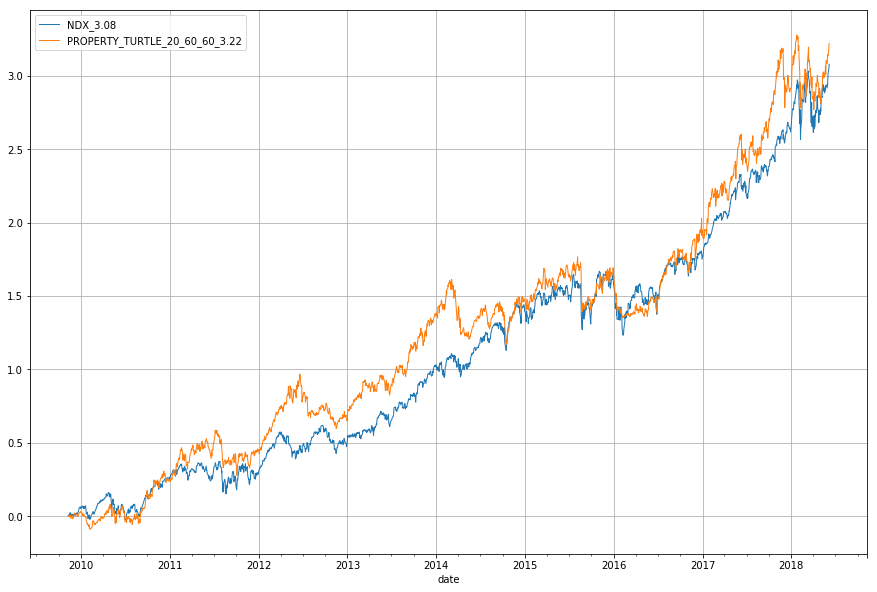

In [12]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

df = show_df.dropna(how='any', inplace=False).copy()
# df.drop(columns=['open', 'high', 'low', 'o_pct_chg', 'TR', 'N'], inplace=True)
df.columns

df['close'] = (df['close'] - df.iloc[0]['close']) / df.iloc[0]['close']
ax = df.plot(kind='line', y='close', label='NDX_%.2f' % df.iloc[-1]['close'], linewidth=1, grid=True)
for col in sorted(df.columns):
    if 'PROPERTY' in col:
        df[col] = (df[col] - df.iloc[1][col]) / df.iloc[0][col]
        ax = df.plot(kind='line', y=col, secondary_y=False, label='%s_%.2f' % (col, df.iloc[-1][col]), linewidth=1, grid=True, ax=ax)

# display_charts(df, kind='line', figsize=(900, 600), logy=False)